# Testing a simple Deep learning model using same input as the Random Forest Regression model

## Imports

In [178]:
## Useful libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
import copy
import pickle
from urllib.request import urlretrieve
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.colors import TwoSlopeNorm
from torchsummary import summary
from cycler import cycler
import seaborn as sns
import pandas as pd
import random
import torch.optim as optim
from sklearn.model_selection import train_test_split
# Set the color scheme
sns.set_theme()
colors = ['#0076C2', '#EC6842', '#A50034', '#009B77', '#FFB81C', '#E03C31', '#6CC24A', '#EF60A3', '#0C2340', '#00B8C8', '#6F1D77']
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [179]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/Utbyte 2024/Data science and Artifical Intelligence/Groundwater Project/Data'  # Example path

%cd "$folder_path"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Utbyte 2024/Data science and Artifical Intelligence/Groundwater Project/Data


## In theory at least should make seed identical for all runs

In [180]:
random.seed(42)
random_num = random.randint(0, 1000)

# Set random seed for Python's random module
random.seed(random_num)

# Set random seed for NumPy
np.random.seed(random_num)

# Set random seed for PyTorch (CPU and GPU)
torch.manual_seed(random_num)
torch.cuda.manual_seed(random_num)  # Only use if you need to set GPU seed
torch.cuda.manual_seed_all(random_num)

## Data collection

In [181]:
# train_params = ['Rain mm/y', 'rainfall_seasonality', 'PET mm/y', 'elevation_mahd', 'distance_to_coast_km', 'ndvi_avg', 'clay_perc', 'soil_class']
train_params = ['Rain mm/y', 'rainfall_seasonality', 'PET mm/y']
y_var = 'Recharge RC 50% mm/y'
train_data_file = 'train_data.csv'
train_data = pd.read_csv(train_data_file)

# Assign features and target variable, make into arrays
X = train_data[train_params].values
y = train_data[y_var].values

# Split data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_num)
# Preprocess the data
scaler = StandardScaler()              # For scaling
X_train_scaled = scaler.fit_transform(X_train)     # Fit and transform training data
X_val_scaled = scaler.transform(X_val)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)  # Reshape for single output
X_val_tensor = torch.FloatTensor(X_val_scaled)  # For validation data
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)  # Reshape


batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=lambda worker_id: np.random.seed(random_num + worker_id))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Model

In [182]:
class SimpleFNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super(SimpleFNN, self).__init__()

        # Create a list to collect the layers
        layers = []

        # Input layer to first hidden layer
        layers.append(nn.Linear(input_dim, hidden_layers[0]))
        layers.append(nn.ReLU(inplace=True))

        # Create hidden layers
        '''
        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            layers.append(nn.ReLU(inplace=True))
        '''
        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            # Alternate activation functions
            if i % 2 == 1:  # Odd index: Tanh
                layers.append(nn.Tanh())
            else:           # Even index: ReLU
                layers.append(nn.ReLU(inplace=True))
        # Output layer
        layers.append(nn.Linear(hidden_layers[-1], output_dim))

        # Combine all layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)  # Forward pass through the model

## Model values

In [183]:
# Define your model (using the SimpleFNN class from the previous step)
input_dim = X.shape[1]  # Number of features
hidden_layers = [32, 64, 32]  # Size of hidden layers
# hidden_layers = [256, 128, 64, 32]  # Deeper architecture with 4 layers
output_dim = 1  # Output dimension (for regression)

model = SimpleFNN(input_dim=input_dim, hidden_layers=hidden_layers, output_dim=output_dim).to(device)

### Loss function and optimizer

In [184]:
criterion = nn.MSELoss()  # Mean Squared Error for regression
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [185]:
def train_epoch(model, train_loader, optimizer, device, max_norm=1.0):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Zero gradients, perform backpropagation, and update weights
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)  # Return average loss

  # Function to evaluate the model on validation data
def evaluation(model, val_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            val_outputs = model(val_X)
            loss = criterion(val_outputs, val_y)
            total_loss += loss.item()

    return total_loss / len(val_loader)  # Return average validation loss

## Training Loop

In [186]:
num_epochs = 20
train_losses = []
val_losses = []

# Training and Validation Loop

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss = train_epoch(model, train_loader, optimizer, device, max_norm=10.0)
    train_losses.append(train_loss)

    # Validate the model
    val_loss = evaluation(model, val_loader, device)
    val_losses.append(val_loss)

    # Print epoch results
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

print("Training complete.")

Epoch [1/20], Train Loss: 5841.2334, Validation Loss: 4620.5630
Epoch [2/20], Train Loss: 4190.0206, Validation Loss: 4487.2028
Epoch [3/20], Train Loss: 3992.3008, Validation Loss: 4114.1454
Epoch [4/20], Train Loss: 3910.4475, Validation Loss: 4204.9759
Epoch [5/20], Train Loss: 3836.0462, Validation Loss: 3903.8022
Epoch [6/20], Train Loss: 3784.0633, Validation Loss: 3938.9133
Epoch [7/20], Train Loss: 3751.7153, Validation Loss: 4092.2612
Epoch [8/20], Train Loss: 3719.6459, Validation Loss: 3805.2008
Epoch [9/20], Train Loss: 3687.5301, Validation Loss: 3809.4008
Epoch [10/20], Train Loss: 3701.8252, Validation Loss: 3900.7307
Epoch [11/20], Train Loss: 3681.0973, Validation Loss: 3871.5203
Epoch [12/20], Train Loss: 3656.5922, Validation Loss: 3865.0155
Epoch [13/20], Train Loss: 3646.8474, Validation Loss: 3898.5655
Epoch [14/20], Train Loss: 3652.1618, Validation Loss: 3785.3808
Epoch [15/20], Train Loss: 3635.7405, Validation Loss: 3893.6399
Epoch [16/20], Train Loss: 3626.88

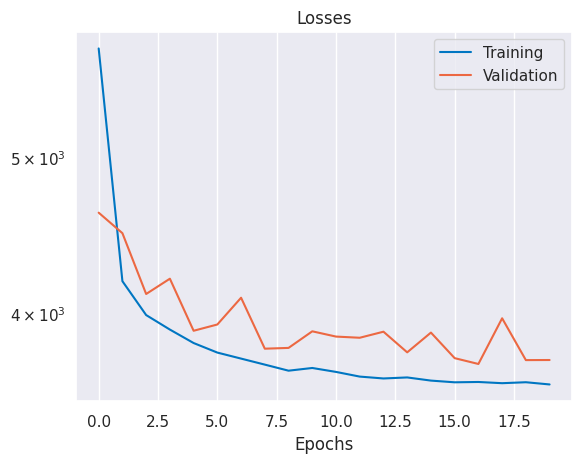

In [187]:
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.yscale('log')
plt.title('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

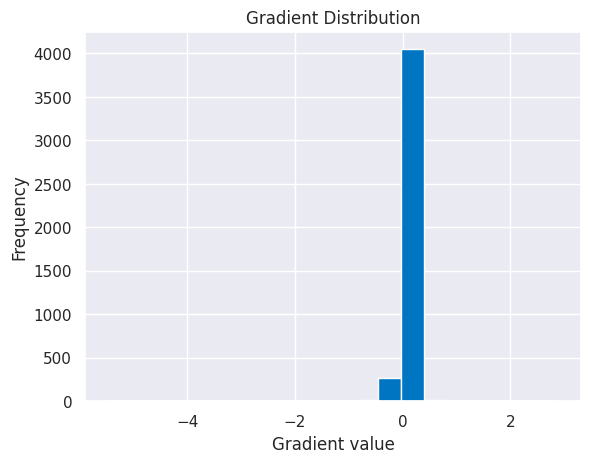

       Mean  Median  Standard Deviation   Minimum   Maximum  Count < -1  \
0  0.000012     0.0            0.151567 -5.477805  2.903226           6   

   Count > 1  Count < -10  Count > 10  
0          9            0           0  


In [188]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

gradients = []
for param in model.parameters():
    if param.grad is not None:
        gradients.append(param.grad.data.cpu().numpy().flatten())

# Concatenate the gradients into a single array
all_gradients = np.concatenate(gradients)

# Plot the histogram
plt.hist(all_gradients, bins=20)
plt.title('Gradient Distribution')
plt.xlabel('Gradient value')
plt.ylabel('Frequency')
plt.show()

# Calculate summary statistics
summary_stats = {
    'Mean': [np.mean(all_gradients)],
    'Median': [np.median(all_gradients)],
    'Standard Deviation': [np.std(all_gradients)],
    'Minimum': [np.min(all_gradients)],
    'Maximum': [np.max(all_gradients)],
}

# Count values smaller than -1 and larger than 1
count_less_than_minus_1 = np.sum(all_gradients < -1)
count_greater_than_1 = np.sum(all_gradients > 1)

# Count values smaller than -10 and larger than 10
count_less_than_minus_10 = np.sum(all_gradients < -10)
count_greater_than_10 = np.sum(all_gradients > 10)

# Update the summary stats with the counts
summary_stats['Count < -1'] = [count_less_than_minus_1]
summary_stats['Count > 1'] = [count_greater_than_1]
summary_stats['Count < -10'] = [count_less_than_minus_10]
summary_stats['Count > 10'] = [count_greater_than_10]

# Create a DataFrame to store the summary statistics
summary_df = pd.DataFrame(summary_stats)

# Display the summary table
print(summary_df)